# FINAL MODELS & FEATURE IMPORTANCE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import timedelta
from tqdm import tqdm

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_log_error as msle

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('final_data.csv')

In [3]:
df.isnull().sum().sum()

0

In [4]:
df.dtypes

WEEK_END_DATE                 object
STORE_NUM                      int64
UPC                            int64
BASE_PRICE                   float64
FEATURE                        int64
DISPLAY                        int64
UNITS                          int64
MONTH                          int64
MANUFACTURER_1                 int64
MANUFACTURER_2                 int64
MANUFACTURER_3                 int64
MANUFACTURER_4                 int64
MANUFACTURER_5                 int64
MANUFACTURER_6                 int64
MANUFACTURER_7                 int64
MANUFACTURER_8                 int64
MANUFACTURER_9                 int64
CATEGORY_1                     int64
CATEGORY_2                     int64
CATEGORY_3                     int64
CATEGORY_4                     int64
SUB_CATEGORY_1                 int64
SUB_CATEGORY_2                 int64
SUB_CATEGORY_3                 int64
SUB_CATEGORY_4                 int64
SUB_CATEGORY_5                 int64
SUB_CATEGORY_6                 int64
S

In [5]:
df.drop(columns = ['2_MONTH_BEFORE', '1_WEEK_BEFORE'], axis =1, inplace = True)

In [6]:
df['WEEK_END_DATE'] = pd.to_datetime(df['WEEK_END_DATE'])

In [7]:
weeks = df['WEEK_END_DATE'].unique()

In [8]:
def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start_1'] = week[w-3-4*no_of_months]
        x_data['train_end_1'] = week[w-4]
        x_data['train_start_2'] = week[w-1-4*no_of_months]
        x_data['valid_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['days_train_1'] = x_data['train_end_1'] - x_data['train_start_1']
        x_data['days_train_2'] = x_data['valid_week'] - x_data['train_start_2']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
        
    
    datapoints = []
    
    for s in model_set:
        
        x = {}
        train_1_set = data[(data['WEEK_END_DATE'] >= s['train_start_1']) & (data['WEEK_END_DATE'] <= s['train_end_1'])]
        train_2_set = data[(data['WEEK_END_DATE'] >= s['train_start_2']) & (data['WEEK_END_DATE'] <= s['valid_week'])]
        x['train1_shape'] = train_1_set.shape[0]
        x['train2_shape'] = train_2_set.shape[0]
        x['valid_shape'] = data[data['WEEK_END_DATE'] == s['valid_week']].shape[0]
        x['test_shape'] = data[data['WEEK_END_DATE'] == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)
        

    df = pd.DataFrame(datapoints)
    df['days_train_1'] = df['days_train_1'] + timedelta(days=7)
    df['days_train_2'] = df['days_train_2'] + timedelta(days=7)
    return df

In [9]:
valid_strat = validation_df(df, weeks, no_of_months=1, no_of_validation=9)
valid_strat

,train1_shape,train2_shape,valid_shape,test_shape,train_start_1,train_end_1,train_start_2,valid_week,test_week,days_train_1,days_train_2,set_no
0,6538,6541,1640,1642,2011-08-10,2011-08-31,2011-08-24,2011-09-14,2011-09-28,28 days,28 days,set1
1,6549,6539,1632,1638,2011-08-03,2011-08-24,2011-08-17,2011-09-07,2011-09-21,28 days,28 days,set2
2,6546,6538,1629,1640,2011-07-27,2011-08-17,2011-08-10,2011-08-31,2011-09-14,28 days,28 days,set3
3,6543,6549,1640,1632,2011-07-20,2011-08-10,2011-08-03,2011-08-24,2011-09-07,28 days,28 days,set4
4,6551,6546,1638,1629,2011-07-13,2011-08-03,2011-07-27,2011-08-17,2011-08-31,28 days,28 days,set5
5,6553,6543,1631,1640,2011-07-06,2011-07-27,2011-07-20,2011-08-10,2011-08-24,28 days,28 days,set6
6,6555,6551,1640,1638,2011-06-29,2011-07-20,2011-07-13,2011-08-03,2011-08-17,28 days,28 days,set7
7,6558,6553,1637,1631,2011-06-22,2011-07-13,2011-07-06,2011-07-27,2011-08-10,28 days,28 days,set8
8,6558,6555,1635,1640,2011-06-15,2011-07-06,2011-06-29,2011-07-20,2011-08-03,28 days,28 days,set9


In [10]:
def get_evaluation_sets(main_data, valid_data):
    
    evaluation_set = []
    
    for row in range(valid_data.shape[0]):
        
        #training-1 data
        train_1 = main_data[(main_data['WEEK_END_DATE'] >= valid_data.iloc[row]['train_start_1']) & (main_data['WEEK_END_DATE'] <= valid_data.iloc[row]['train_end_1'])]
        #validation data
        valid = main_data[main_data['WEEK_END_DATE'] == valid_data.iloc[row]['valid_week']]
        #training-2 data
        train_2 = main_data[(main_data['WEEK_END_DATE'] >= valid_data.iloc[row]['train_start_2']) & (main_data['WEEK_END_DATE'] <= valid_data.iloc[row]['valid_week'])]
        #test data
        test = main_data[main_data['WEEK_END_DATE'] == valid_data.iloc[row]['test_week']]
        
        evaluation_set.append((train_1, valid, train_2, test))
    return evaluation_set

In [11]:
evaluation_sets = get_evaluation_sets(df, valid_strat)

In [12]:
def get_rmsle(true, predicted) :
    return np.sqrt(msle(true, predicted))

Let's define a function to calculate the results on evaluation sets:

In [13]:
def get_results(eval_sets, model):
    
    results = []
    set_n = 1
    for i in tqdm(eval_sets):
        
        x = {}
        
        #==================================================================================
        
        train_1 = i[0]
        valid = i[1]
        train_2 = i[2]
        test = i[3]
        
        train_1_x = train_1.drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_1_y = train_1['UNITS']
        
        valid_x = valid.drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        valid_y = valid['UNITS']
        
        train_2_x = train_2.drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_2_y = train_2['UNITS']
        
        test_x = test.drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        test_y = test['UNITS']
        
        #==================================================================================
        
        valid_model = model.fit(train_1_x, train_1_y)
        train_1_preds = valid_model.predict(train_1_x).clip(min=0)
        valid_preds = valid_model.predict(valid_x).clip(min=0)
        
        test_model = model.fit(train_2_x, train_2_y)
        train_2_preds = test_model.predict(train_2_x).clip(min=0)
        test_preds = test_model.predict(test_x).clip(min=0)
        
        #==================================================================================
        
        train_1_rmsle = get_rmsle(train_1_y, train_1_preds)
        train_2_rmsle = get_rmsle(train_2_y, train_2_preds)
        valid_rmsle = get_rmsle(valid_y, valid_preds)
        test_rmsle = get_rmsle(test_y, test_preds)
        
        #==================================================================================
        
        x['train_1'] = train_1_rmsle
        x['valid'] = valid_rmsle
        x['train_2'] = train_2_rmsle
        x['test'] = test_rmsle
        results.append(x)
        set_n += 1
    
    return pd.DataFrame(results)

In [14]:
def get_feature_importance(eval_set, model):
    
    train_1, valid, train_2, test = eval_set
    
    train_x = train_2.drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    train_y = train_2['UNITS']
        
    test_x = test.drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    test_y = test['UNITS']
    
    model.fit(train_x, train_y)
    (pd.Series(model.feature_importances_, index = train_x.columns).nlargest(10).plot(kind= 'barh'))

### 1. Random Forest

In [16]:
RF = RandomForestRegressor(max_depth= 6, n_estimators= 220, min_samples_split= 5, min_samples_leaf= 16, random_state= 0)

results_RF = get_results(evaluation_sets, RF)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:39<00:00, 11.06s/it]


In [17]:
results_RF

,train_1,valid,train_2,test
0,0.442080,0.423307,0.409222,0.455386
1,0.422775,0.466366,0.418835,0.529516
2,0.418738,0.587325,0.442080,0.423307
3,0.432279,0.516884,0.422775,0.466366
4,0.417890,0.461654,0.418738,0.587325
5,0.422489,0.526442,0.432279,0.516884
6,0.409656,0.441173,0.417890,0.461654
7,0.414800,0.489282,0.422489,0.526442
8,0.409568,0.503986,0.409656,0.441173


In [21]:
print(results_RF[['train_2', 'test']].mean())

RF_score = results_RF[['train_2', 'test']].mean()[1]

train_2    0.421552
test       0.489784
dtype: float64


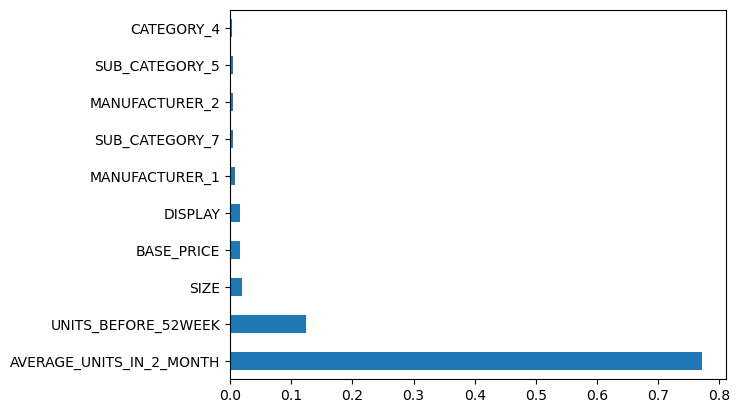

In [19]:
get_feature_importance(evaluation_sets[0], RF)

We can see that:

* We have a **mean training RMSLE: 0.4215**
* and a **mean test RMSLE: 0.4897**
* Last 2 month's Average Unit Sales (**AVERAGE_UNITS_IN_2_MONTH**) feature of the dataset has contributed most to the prediction algorithm.
* **UNITS_BEFORE_52WEEK** feature which contains the units sold an year ago for the same combination of STORE_NUM & UPC is the second largest contributing feature of the model.
* The third feature which has contributed most is **SIZE**

### 2. XGBoost

In [22]:
XGB = xgb.XGBRegressor(n_estimators= 220,
                       max_depth= 6,
                       learning_rate= 0.01,
                       gamma= 0,
                       min_child_weight= 1,
                       subsample= 0.1,
                       n_jobs = -1,
                       random_state = 0,
                       objective ='reg:squarederror')

In [23]:
results_XGB = get_results(evaluation_sets, XGB)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.32s/it]


In [24]:
results_XGB

,train_1,valid,train_2,test
0,0.404809,0.435271,0.376927,0.462437
1,0.384615,0.456824,0.374891,0.547306
2,0.384336,0.525813,0.404809,0.435271
3,0.391659,0.471302,0.384615,0.456824
4,0.375714,0.410676,0.384336,0.525813
5,0.377216,0.487810,0.391659,0.471302
6,0.369267,0.451297,0.375714,0.410676
7,0.373032,0.462551,0.377216,0.487810
8,0.367823,0.422275,0.369267,0.451297


In [25]:
print(results_XGB[['train_2', 'test']].mean())
XGB_score = results_XGB[['train_2', 'test']].mean()[1]

train_2    0.382159
test       0.472082
dtype: float64


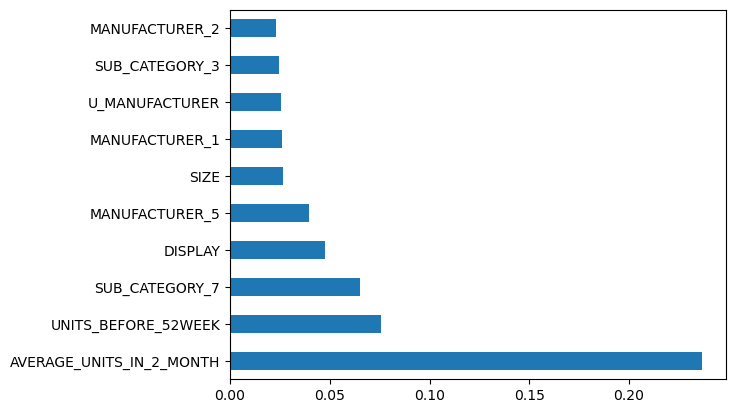

In [26]:
get_feature_importance(evaluation_sets[0], XGB)

We can see that:

* We have a **mean training RMSLE: 0.3821**
* and a **mean test RMSLE: 0.4720** 
* Last 2 month's Average Unit Sales (**AVERAGE_UNITS_IN_2_MONTH**) feature of the dataset has contributed most to the prediction algorithm.
* The second feature which has contributed most is **UNITS_BEFORE_52WEEK**. This feature contains the units sold an year ago for the same combination of STORE_NUM & UPC.
* **SUB_CATEGORY_7** is the third largest contributing feature of the model.

### 3. Light-GBM

In [27]:
LGBM = LGBMRegressor(n_estimators = 640,
                     learning_rate = 0.01,
                     min_child_samples = 5,
                     subsample = 0,
                     n_jobs = -1,
                     random_state = 0,
                     num_leaves = 18,
                     bagging_fraction=0.8,
                     boosting_type = 'gbdt',
                     objective = 'regression',
                     verbosity = -1)

In [28]:
results_LGBM = get_results(evaluation_sets, LGBM)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.44s/it]


In [29]:
results_LGBM

,train_1,valid,train_2,test
0,0.380172,0.404523,0.361080,0.418715
1,0.380029,0.472616,0.360513,0.524072
2,0.387072,0.566776,0.380172,0.404523
3,0.395934,0.486582,0.380029,0.472616
4,0.377798,0.436554,0.387072,0.566776
5,0.373859,0.536028,0.395934,0.486582
6,0.364797,0.437948,0.377798,0.436554
7,0.364918,0.469735,0.373859,0.536028
8,0.359642,0.451304,0.364797,0.437948


In [30]:
print(results_LGBM[['train_2', 'test']].mean())
LGBM_score = results_LGBM[['train_2', 'test']].mean()[1]

train_2    0.375695
test       0.475979
dtype: float64


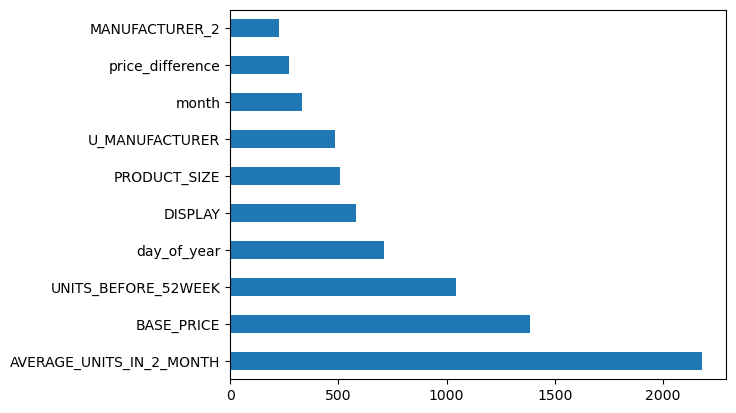

In [86]:
get_feature_importance(evaluation_sets[0], LGBM)

We can see that:

* We have a **mean training RMSLE: 0.3756**
* and a **mean test RMSLE: 0.4759** 
* Last 2 month's Average Unit Sales (**AVERAGE_UNITS_IN_2_MONTH**) feature of the dataset has contributed most to the prediction algorithm.
* The second feature which has contributed most is **BASE_PRICE**
* **UNITS_BEFORE_52WEEK** feature which contains the units sold an year ago for the same combination of STORE_NUM & UPC is the third largest contributing feature of the model.


### 4. SCORE COMPARISON

In [33]:
score_matrix = pd.DataFrame([{'RF': RF_score,
                'XGB': XGB_score,
                'LGBM': LGBM_score}])
score_matrix

,RF,XGB,LGBM
0,0.489784,0.472082,0.475979


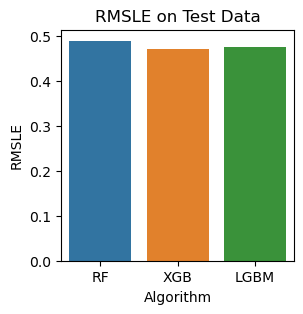

In [40]:
plt.figure(figsize= (3,3), dpi= 100)
sns.barplot(x= score_matrix.iloc[0].index, y = score_matrix.iloc[0].values)
plt.title('RMSLE on Test Data')
plt.xlabel('Algorithm')
plt.ylabel('RMSLE')
plt.show()

### RMSLE on XGB is the lowest so XGBRegressor is the Optimal Algorithm for this problem.